<a href="https://colab.research.google.com/github/Lorenzdm93/Udacity-Data-Product-Manager/blob/main/FlyberTestUdacityFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Prompt to upload the file
uploaded = files.upload()

Saving Flyber_event_logs.csv to Flyber_event_logs (1).csv


In [ ]:
import os

# List files in the current working directory
print(os.listdir())

['.config', 'Flyber_event_logs.csv', 'Flyber_event_logs (1).csv', 'sample_data']


In [ ]:
import pandas as pd
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)
df.head()

,event_uuid,user_uuid,event_time,age,session_uuid,experiment_group,user_neighborhood,event_type
0,b9e9489e-1218-4715-b42e-604e3745db07,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:34:23,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,open
1,a4ff8e2c-2701-4a32-9029-bdf6efc155c5,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:36:45,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,#_of_users
2,41b4f6b1-cc14-4c77-a520-50c1cb9cd592,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:37:31,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,search
3,73b945e9-691e-4e63-aa4d-da2f74599388,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-12 06:27:13,40-49,8a08005b-7e74-4664-b25d-9e29d8316d71,experiment_1,Manhattan,open
4,a070700c-8bd9-4b5a-9325-e029fda604c7,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-12 06:28:10,40-49,8a08005b-7e74-4664-b25d-9e29d8316d71,experiment_1,Manhattan,#_of_users


In [ ]:
df1 = df.copy()

In [ ]:
def perform_quality_checks(df1):
    # Check for missing values
    missing_values = df1.isnull().sum()
    # Check data types
    data_types = df1.dtypes
    # Check for duplicate rows
    duplicate_rows = df1[df1.duplicated()]
    # Summary of quality checks
    summary = {
        'Missing Values': missing_values,
        'Data Types': data_types,
        'Duplicate Rows': duplicate_rows
      }
    return summary

# Perform quality checks
quality_check_results = perform_quality_checks(df1)

# Display the results
for check, result in quality_check_results.items():
    print(f"\n{check}:\n{result}")


Missing Values:
event_uuid           0
user_uuid            0
event_time           0
age                  0
session_uuid         0
experiment_group     0
user_neighborhood    0
event_type           0
dtype: int64

Data Types:
event_uuid           object
user_uuid            object
event_time           object
age                  object
session_uuid         object
experiment_group     object
user_neighborhood    object
event_type           object
dtype: object

Duplicate Rows:
Empty DataFrame
Columns: [event_uuid, user_uuid, event_time, age, session_uuid, experiment_group, user_neighborhood, event_type]
Index: []


In [ ]:
df1 = df1.rename(columns={df.columns[0]: 'row_id'})
df1['event_time'] = pd.to_datetime(df1['event_time'])
df1['day'] = df1['event_time'].dt.strftime('%d-%m-%Y')

In [ ]:
rides_df = df1[df1['event_type'] == 'begin_ride']

#calculate the number of rides per week and per month
daily_rides = rides_df.groupby('day').size()

#display the results
print("Daily Rides:")
print(daily_rides)

Daily Rides:
day
05-10-2019     54
06-10-2019     95
07-10-2019    116
08-10-2019     98
09-10-2019     77
10-10-2019     87
11-10-2019    107
12-10-2019     43
dtype: int64


In [ ]:
distinct_values = df['event_type'].unique()
print(distinct_values)

['open' '#_of_users' 'search' 'begin_ride']


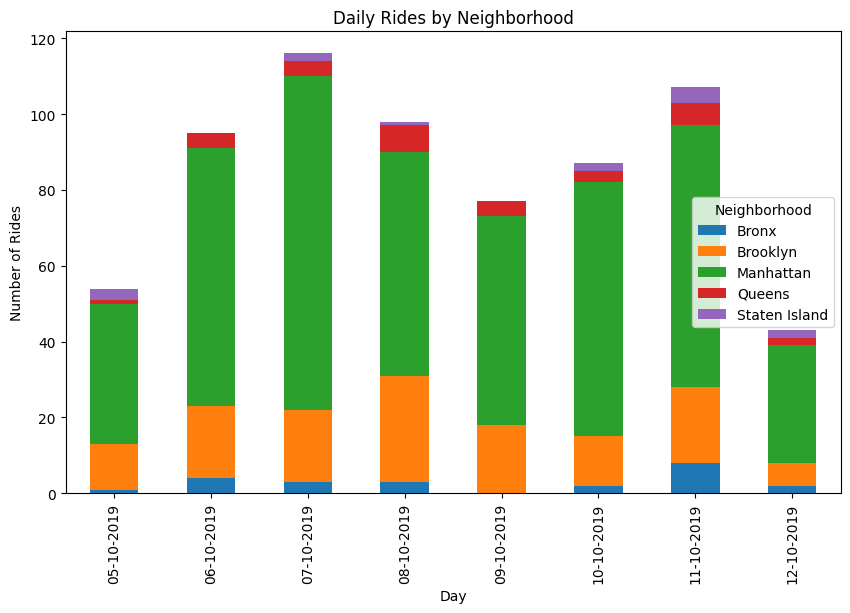

In [ ]:
import matplotlib.pyplot as plt

## KPI 1 - Volume of rides over time by Neighborhood

#group by 'day' and 'user_neighborhood' to count the number of rides for each neighborhood each day
daily_rides_by_neighborhood = rides_df.groupby(['day', 'user_neighborhood']).size().unstack(fill_value=0)

#plotting a stacked bar chart
daily_rides_by_neighborhood.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Daily Rides by Neighborhood')
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.legend(title='Neighborhood')
plt.show()


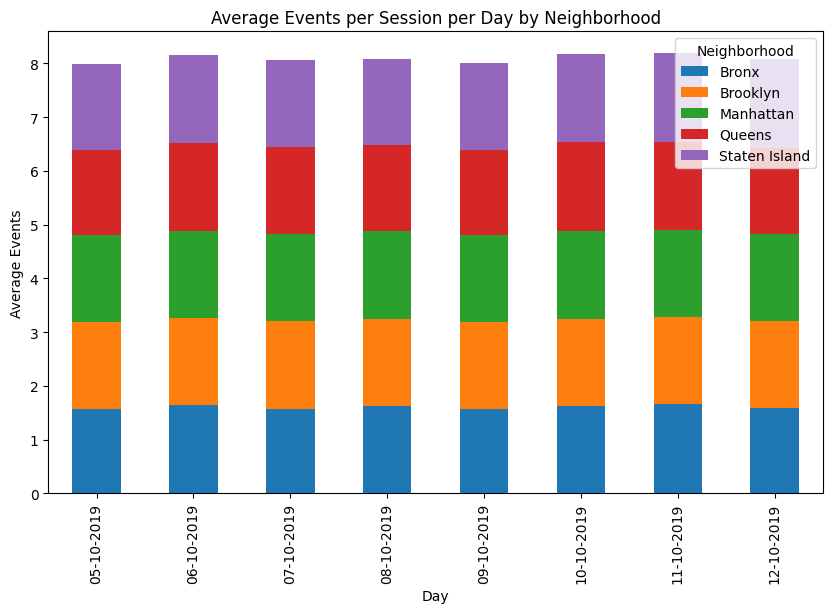

In [ ]:
## KPI 2 - Average events per session (user level) over time

# group by 'user_uuid', 'day', and 'user_neighborhood' to count the number of events per session per day
events_per_session_per_day = df1.groupby(['day','session_uuid', 'user_neighborhood']).size().reset_index(name='events_count')

# calculate the average number of events per session per day
average_events_per_session_per_day = events_per_session_per_day.groupby(['day', 'user_neighborhood'])['events_count'].mean().unstack(fill_value=0)

# plotting a stacked bar chart
average_events_per_session_per_day.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average Events per Session per Day by Neighborhood')
plt.xlabel('Day')
plt.ylabel('Average Events')
plt.legend(title='Neighborhood')
plt.show()

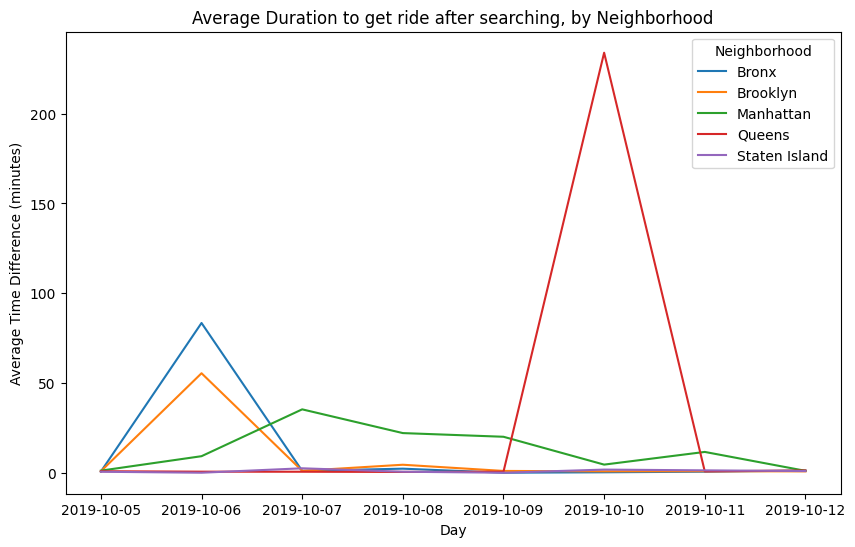

In [ ]:
## KPI 3 - Average arrival time of taxi from search by neighbourhood

#filter for 'search' and 'begin_ride' events
search_events = df1[df1['event_type'] == 'search']
begin_ride_events = df1[df1['event_type'] == 'begin_ride']

#merge 'search' and 'begin_ride' events based on 'user_uuid' and 'day'
merged_events = pd.merge(search_events, begin_ride_events, on=['user_uuid', 'day'], suffixes=('_search', '_begin_ride'))

#calculate the time difference for each ride
merged_events['time_difference'] = ((merged_events['event_time_begin_ride'] - merged_events['event_time_search'])/ 60).dt.total_seconds()

#ensure 'day' is a separate column
merged_events['day'] = merged_events['event_time_search'].dt.date
#restrict the DataFrame to relevant columns
merged_events = merged_events[['user_uuid', 'event_time_search', 'event_time_begin_ride', 'day', 'user_neighborhood_search','time_difference']]
#filter out negative time differences (some users may have search for a second ride)
merged_events = merged_events[merged_events['time_difference'] >= 0]

#calculate the average time difference per day and per neighborhood
average_time_difference = merged_events.groupby(['day', 'user_neighborhood_search'])['time_difference'].mean().unstack(fill_value=0)

#plotting line chart
average_time_difference.plot(kind='line', stacked=False, figsize=(10, 6))
plt.title('Average Duration to get ride after searching, by Neighborhood')
plt.xlabel('Day')
plt.ylabel('Average Time Difference (minutes)')
plt.legend(title='Neighborhood')
plt.show()

In [ ]:
distinct_values = df['experiment_group'].unique()
print(distinct_values)

['experiment_1' 'control' 'experiment_2' 'experiment_3']


Since there are 4 categories in the multivariate test, we need to analyse the effect of the conversion rate according to those.

We need to check for each of the 4 categories, how many rides were booked in comparison to the users that opened the app.



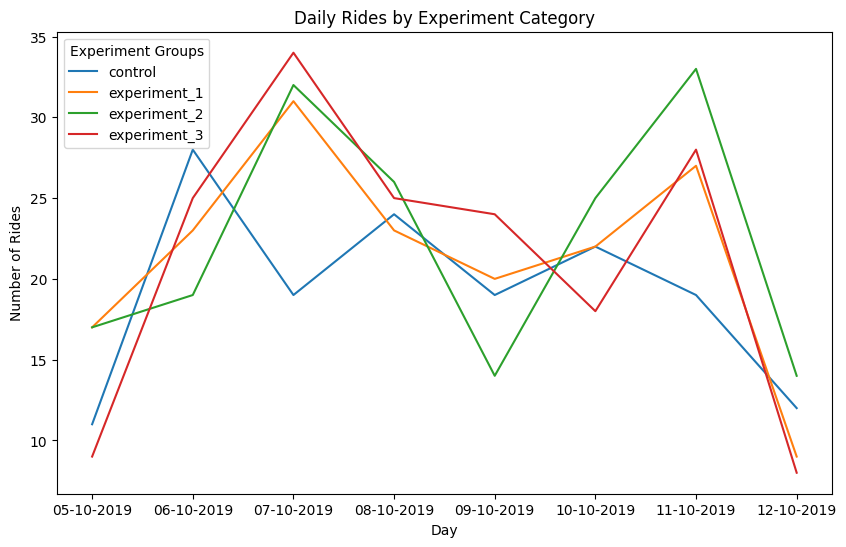

In [ ]:
daily_rides_by_category = rides_df.groupby(['day', 'experiment_group']).size().unstack(fill_value=0)

#plotting line chart
daily_rides_by_category.plot(kind='line', stacked=False, figsize=(10, 6))
plt.title('Daily Rides by Experiment Category')
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.legend(title='Experiment Groups')
plt.show()

In [ ]:
#separate DataFrames for open and begin_ride with all relevant columns
open_df = df1[df1['event_type'] == 'open'][['session_uuid', 'event_type', 'day', 'user_uuid', 'experiment_group']]
begin_ride_df = df1[df1['event_type'] == 'begin_ride'][['session_uuid', 'event_type', 'day', 'user_uuid', 'experiment_group']]

#merge the two DataFrames on session
merged_df = pd.merge(open_df, begin_ride_df, on='session_uuid', how='outer', suffixes=('_open', '_begin_ride'))

In [ ]:
merged_df.head()

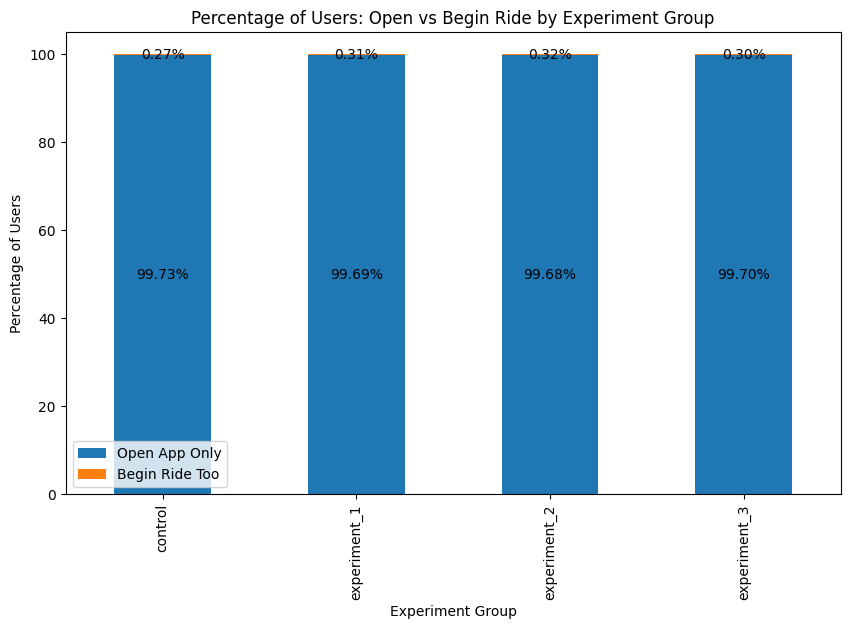

In [ ]:
#count rows with nulls and non-nulls under experiment_group_begin_ride
opened_app_only = merged_df['experiment_group_begin_ride'].isnull().groupby(merged_df['experiment_group_open']).sum()
begin_ride = merged_df['experiment_group_begin_ride'].notnull().groupby(merged_df['experiment_group_open']).sum()

#calculate percentages
total_count = opened_app_only + begin_ride
opened_app_only_perc = (opened_app_only / total_count) * 100
begin_ride_perc = (begin_ride / total_count) * 100

#create a DataFrame with percentages
percentage_df = pd.DataFrame({'Open App Only': opened_app_only_perc, 'Begin Ride Too': begin_ride_perc})

#plot the percentages by experiment_group over days with values displayed
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of Users: Open vs Begin Ride by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Percentage of Users')

#display values on the chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.show()

In [ ]:
print(opened_app_only)
print(begin_ride)
print(percentage_df)

experiment_group_open
control         56236
experiment_1    56218
experiment_2    56508
experiment_3    56516
Name: experiment_group_begin_ride, dtype: int64
experiment_group_open
control         154
experiment_1    172
experiment_2    180
experiment_3    171
Name: experiment_group_begin_ride, dtype: int64
                       Open App Only  Begin Ride Too
experiment_group_open                               
control                    99.726902        0.273098
experiment_1               99.694981        0.305019
experiment_2               99.682472        0.317528
experiment_3               99.698344        0.301656


## Let us now analyse the funnel with conversion rates

In [ ]:
from google.colab import files

# Prompt to upload the file
uploaded = files.upload()

Saving Flyber_event_logs.csv to Flyber_event_logs (2).csv


In [ ]:
import os
import pandas as pd

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

In [ ]:
filtered_df = df[df['session_uuid'] == '2d7b8da3-573a-447f-9964-acf32526b1db']
filtered_df.head()


,event_uuid,user_uuid,event_time,age,session_uuid,experiment_group,user_neighborhood,event_type
0,b9e9489e-1218-4715-b42e-604e3745db07,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:34:23,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,open
1,a4ff8e2c-2701-4a32-9029-bdf6efc155c5,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:36:45,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,#_of_users
2,41b4f6b1-cc14-4c77-a520-50c1cb9cd592,8191a8b8-9445-4661-9500-2bed275576f6,2019-10-06 05:37:31,40-49,2d7b8da3-573a-447f-9964-acf32526b1db,experiment_1,Manhattan,search


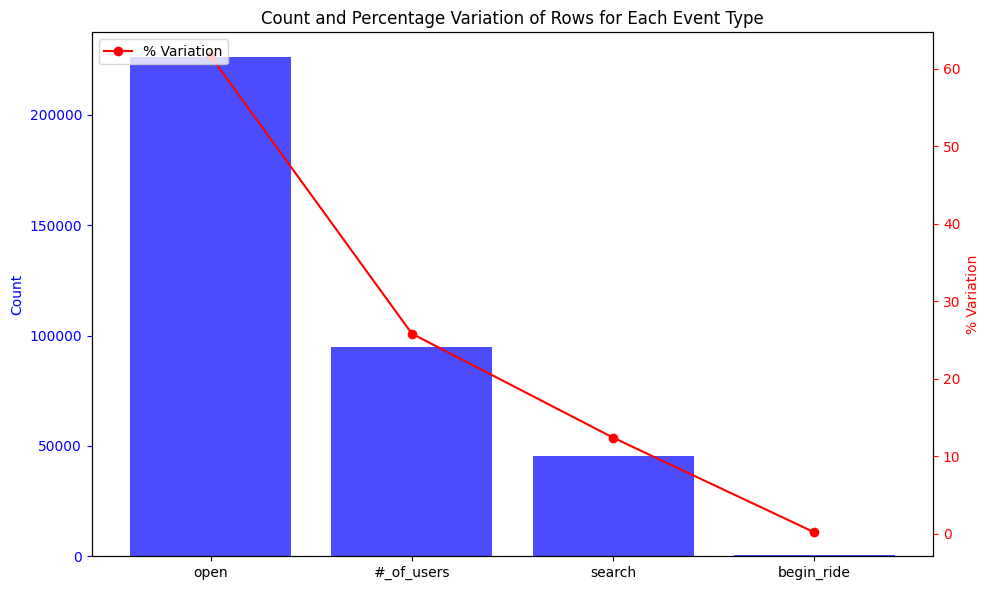

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

event_type_counts = df['event_type'].value_counts()

#calculate the percentage variation
percentage_variation = (event_type_counts / event_type_counts.sum()) * 100

#plot the counts and percentage variation in a bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

#plot absolute values on the left y-axis
ax1.bar(event_type_counts.index, event_type_counts, color='b', alpha=0.7, label='Absolute Values')
ax1.set_ylabel('Count', color='b')
ax1.tick_params('y', colors='b')

#create a secondary y-axis for percentage variation on the right
ax2 = ax1.twinx()
ax2.plot(event_type_counts.index, percentage_variation, color='r', marker='o', label='% Variation')
ax2.set_ylabel('% Variation', color='r')
ax2.tick_params('y', colors='r')

#add labels and title
plt.xlabel('Event Type')
plt.title('Count and Percentage Variation of Rows for Each Event Type')

#show the legend
fig.tight_layout()
plt.legend(loc='upper left')
#show the plot
plt.show()

In [ ]:
print(event_type_counts)
print(percentage_variation)

open          226155
#_of_users     94748
search         45503
begin_ride       677
Name: event_type, dtype: int64
open          61.608683
#_of_users    25.811056
search        12.395834
begin_ride     0.184427
Name: event_type, dtype: float64


In [ ]:
age_neighborhood_counts = df.groupby(['age', 'user_neighborhood']).size().reset_index(name='count')
age_neighborhood_counts = age_neighborhood_counts.sort_values(by='count', ascending=False)
print(age_neighborhood_counts)

      age user_neighborhood   count
17    50+         Manhattan  123645
12  40-49         Manhattan   66599
2   18-29         Manhattan   40165
16    50+          Brooklyn   35379
7   30-39         Manhattan   26850
11  40-49          Brooklyn   19183
1   18-29          Brooklyn   11641
18    50+            Queens    8603
6   30-39          Brooklyn    7677
15    50+             Bronx    5190
13  40-49            Queens    4720
19    50+     Staten Island    3378
3   18-29            Queens    2835
10  40-49             Bronx    2740
8   30-39            Queens    1930
14  40-49     Staten Island    1926
0   18-29             Bronx    1686
5   30-39             Bronx    1186
4   18-29     Staten Island    1037
9   30-39     Staten Island     713


In [ ]:
df = df.rename(columns={df.columns[0]: 'row_id'})
df['event_time'] = pd.to_datetime(df['event_time'])
df['day'] = df['event_time'].dt.strftime('%d-%m-%Y')

In [ ]:
df['age_neighborhood'] = df['age'].astype(str) + '_' + df['user_neighborhood']

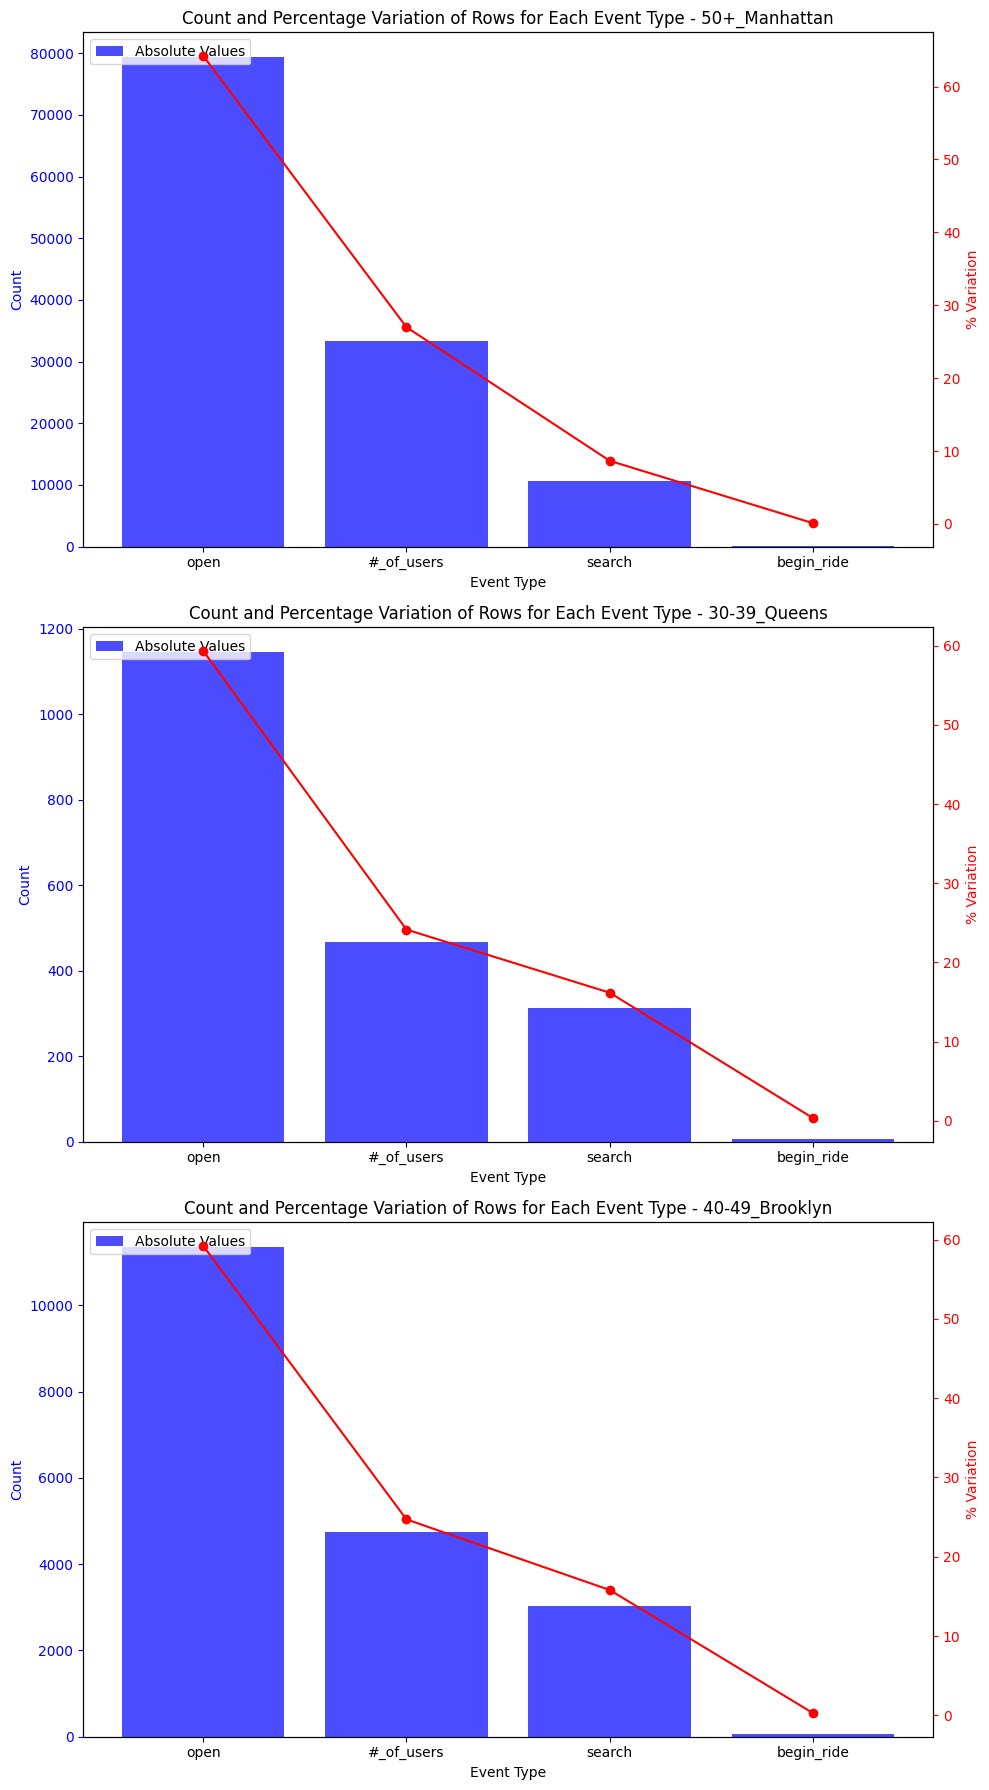

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'age_neighborhood_values' with actual values present in your dataset
age_neighborhood_values = ['50+_Manhattan', '30-39_Queens', '40-49_Brooklyn']

# Create a list to store DataFrames for each segment
dfs_by_age_neighborhood = []

# Iterate over age_neighborhood values and create DataFrames
for value in age_neighborhood_values:
    age_neighborhood_df = df[df['age_neighborhood'] == value]
    dfs_by_age_neighborhood.append(age_neighborhood_df)

# Create subplots for the multi-chart
fig, axes = plt.subplots(nrows=len(dfs_by_age_neighborhood), ncols=1, figsize=(10, 6 * len(dfs_by_age_neighborhood)))

# Iterate over DataFrames and plot absolute volumes and percentage variations
for i, age_neighborhood_df in enumerate(dfs_by_age_neighborhood):
    event_type_counts = age_neighborhood_df['event_type'].value_counts()
    percentage_variation = (event_type_counts / event_type_counts.sum()) * 100

    # Plot absolute values on the left y-axis
    axes[i].bar(event_type_counts.index, event_type_counts, color='b', alpha=0.7, label='Absolute Values')
    axes[i].set_ylabel('Count', color='b')
    axes[i].tick_params('y', colors='b')

    # Create a secondary y-axis for percentage variation on the right
    ax2 = axes[i].twinx()
    ax2.plot(event_type_counts.index, percentage_variation, color='r', marker='o', label='% Variation')
    ax2.set_ylabel('% Variation', color='r')
    ax2.tick_params('y', colors='r')

    # Add labels and title
    axes[i].set_xlabel('Event Type')
    axes[i].set_title(f'Count and Percentage Variation of Rows for Each Event Type - {age_neighborhood_values[i]}')
    axes[i].legend(loc='upper left')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()


In [ ]:
# Create a DataFrame to store counts
counts_df = df.groupby(['age', 'user_neighborhood', 'event_type']).size().reset_index(name='counts')

# Pivot the table for better readability
counts_pivot = counts_df.pivot_table(index=['age', 'user_neighborhood'], columns='event_type', values='counts', fill_value=0)

# Display the counts table
print("Counts Table:")
print(counts_pivot)

# Calculate the percentage variation for each age_neighborhood combination across event_types
total_counts = counts_df.groupby(['age', 'user_neighborhood'])['counts'].sum().reset_index(name='total_counts')
percentage_variation_df = pd.merge(counts_df, total_counts, on=['age', 'user_neighborhood'])
percentage_variation_df['percentage_variation'] = (percentage_variation_df['counts'] / percentage_variation_df['total_counts']) * 100

# Pivot the percentage variation table for better readability
perc_variation_pivot = percentage_variation_df.pivot_table(index=['age', 'user_neighborhood'], columns='event_type', values='percentage_variation', fill_value=0)

# Display the percentage variation table
print("\nPercentage Variation Table:")
print(perc_variation_pivot)


Counts Table:
event_type               #_of_users  begin_ride   open  search
age   user_neighborhood                                       
18-29 Bronx                     413           3   1003     267
      Brooklyn                 2903          20   6894    1824
      Manhattan                9944          95  23708    6418
      Queens                    709           5   1647     474
      Staten Island             253           3    626     155
30-39 Bronx                     285           4    715     182
      Brooklyn                 1900          19   4587    1171
      Manhattan                6645          69  15892    4244
      Queens                    466           6   1146     312
      Staten Island             181           2    420     110
40-49 Bronx                     669          10   1631     430
      Brooklyn                 4740          51  11361    3031
      Manhattan               16502         180  39341   10576
      Queens                   1162      

In [ ]:
# Create a DataFrame to store counts for age
counts_age_df = df.groupby(['age', 'event_type']).size().reset_index(name='counts')

# Pivot the table for better readability
counts_age_pivot = counts_age_df.pivot_table(index='age', columns='event_type', values='counts', fill_value=0)

# Display the counts table for age
print("Counts Table for Age:")
print(counts_age_pivot)

# Calculate the percentage variation for each age across event_types
total_counts_age = counts_age_df.groupby('age')['counts'].sum().reset_index(name='total_counts')
percentage_variation_age_df = pd.merge(counts_age_df, total_counts_age, on='age')
percentage_variation_age_df['percentage_variation'] = (percentage_variation_age_df['counts'] / percentage_variation_age_df['total_counts']) * 100

# Pivot the percentage variation table for better readability
perc_variation_age_pivot = percentage_variation_age_df.pivot_table(index='age', columns='event_type', values='percentage_variation', fill_value=0)

# Display the percentage variation table for age
print("\nPercentage Variation Table for Age:")
print(perc_variation_age_pivot)


Counts Table for Age:
event_type  #_of_users  begin_ride    open  search
age                                               
18-29            14222         126   33878    9138
30-39             9477         100   22760    6019
40-49            23566         256   56256   15090
50+              47483         195  113261   15256

Percentage Variation Table for Age:
event_type  #_of_users  begin_ride       open     search
age                                                     
18-29        24.792553    0.219650  59.057946  15.929851
30-39        24.707999    0.260715  59.338826  15.692460
40-49        24.762525    0.268998  59.112307  15.856170
50+          26.949119    0.110673  64.281620   8.658588


In [ ]:
# Create a DataFrame to store counts for user_neighborhood
counts_neighborhood_df = df.groupby(['user_neighborhood', 'event_type']).size().reset_index(name='counts')

# Pivot the table for better readability
counts_neighborhood_pivot = counts_neighborhood_df.pivot_table(index='user_neighborhood', columns='event_type', values='counts', fill_value=0)

# Display the counts table for user_neighborhood
print("\nCounts Table for User Neighborhood:")
print(counts_neighborhood_pivot)

# Calculate the percentage variation for each user_neighborhood across event_types
total_counts_neighborhood = counts_neighborhood_df.groupby('user_neighborhood')['counts'].sum().reset_index(name='total_counts')
percentage_variation_neighborhood_df = pd.merge(counts_neighborhood_df, total_counts_neighborhood, on='user_neighborhood')
percentage_variation_neighborhood_df['percentage_variation'] = (percentage_variation_neighborhood_df['counts'] / percentage_variation_neighborhood_df['total_counts']) * 100

# Pivot the percentage variation table for better readability
perc_variation_neighborhood_pivot = percentage_variation_neighborhood_df.pivot_table(index='user_neighborhood', columns='event_type', values='percentage_variation', fill_value=0)

# Display the percentage variation table for user_neighborhood
print("\nPercentage Variation Table for User Neighborhood:")
print(perc_variation_neighborhood_pivot)



Counts Table for User Neighborhood:
event_type         #_of_users  begin_ride    open  search
user_neighborhood                                        
Bronx                    2758          23    6693    1328
Brooklyn                19059         135   45583    9103
Manhattan               66471         474  158366   31948
Queens                   4628          31   11172    2257
Staten Island            1832          14    4341     867

Percentage Variation Table for User Neighborhood:
event_type         #_of_users  begin_ride       open     search
user_neighborhood                                              
Bronx               25.532309    0.212924  61.960748  12.294020
Brooklyn            25.797239    0.182729  61.698701  12.321332
Manhattan           25.838163    0.184250  61.558974  12.418613
Queens              25.586024    0.171384  61.764706  12.477886
Staten Island       25.971080    0.198469  61.539552  12.290899


## Another dataset to read interviews

In [ ]:
from google.colab import files
import os
import pandas as pd

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df2 = pd.read_csv(file_name)
df2.head()

Saving Flyber User Interviews.csv to Flyber User Interviews.csv


,Name,Age,Profession,How Often Do You Use Flyber?,What Do You Use When You Don't Use Flyber?,What do you like about Flyber?,Where are you going when you use Flyber?
0,Fahim Burke,25,Trust Fund Kid,Every couple months,"My family has a private jet, so I only use Fly...",I don't feel like a common driver; I can get a...,"Somewhere out of manhattan, like a cool underg..."
1,Pharrell Campos,22,Influencer,1X a week,Sponsors often pay for me to use their vehicle...,It is super cool to arrive to an art gallery o...,"Like I said, I'm always going to new places an..."
2,Keelan Flores,39,Real Estate,3+ times a week,"If the timing isn't different, I'll take a tax...","I'm in real estate, so I have showings all ove...","To check out a new property, or show a propert..."
3,Kayleigh Mcintosh,42,Plastic Surgeon,1X a month,"Before I started using Flyber, I would use a n...",I like the ability to get home quickly after a...,Usually I take flyber as a treat when I'm exha...
4,Kierran Blackburn,55,Real Estate,1X a month,I just hail a taxi or tell my phone to call a ...,I like being able to go from showing to anothe...,"Generally if a showing runs late, I will pull ..."


In [ ]:
df2.columns = df2.columns.str.replace(' ', '_')
event_type_counts = df2['How_Often_Do_You_Use_Flyber?'].value_counts()

In [ ]:
df2.head(100)

,Name,Age,Profession,How_Often_Do_You_Use_Flyber?,What_Do_You_Use_When_You_Don't_Use_Flyber?,What_do_you_like_about_Flyber?,Where_are_you_going_when_you_use_Flyber?
0,Fahim Burke,25,Trust Fund Kid,Every couple months,"My family has a private jet, so I only use Fly...",I don't feel like a common driver; I can get a...,"Somewhere out of manhattan, like a cool underg..."
1,Pharrell Campos,22,Influencer,1X a week,Sponsors often pay for me to use their vehicle...,It is super cool to arrive to an art gallery o...,"Like I said, I'm always going to new places an..."
2,Keelan Flores,39,Real Estate,3+ times a week,"If the timing isn't different, I'll take a tax...","I'm in real estate, so I have showings all ove...","To check out a new property, or show a propert..."
3,Kayleigh Mcintosh,42,Plastic Surgeon,1X a month,"Before I started using Flyber, I would use a n...",I like the ability to get home quickly after a...,Usually I take flyber as a treat when I'm exha...
4,Kierran Blackburn,55,Real Estate,1X a month,I just hail a taxi or tell my phone to call a ...,I like being able to go from showing to anothe...,"Generally if a showing runs late, I will pull ..."
5,Sapphire Dupont,60,Surgeon,2X a month,"Before Flyber, I'd call a taxi service on the ...",I volunteer as a pro-bono surgeon a couple tim...,To the hospital where a patient is located.
6,Tanner Cherry,72,Retired,3+ times a week,Drive my car or call a taxi service.,Flying is so much fun! Plus my wife doesn't li...,All over! It is faster than driving and I don'...
7,Louis Jones,70,Oil Magnate,"5+ times a month, during the 6 months/year I'm...",I have a personal car service on call. My assi...,Flyber gives me the convenience I already have...,Generally between business meetings in the city
8,Robbie Gates,67,"VP, Fortune 50",Tried it once,"Honestly, I thought about using Flyber to supr...",It would be great to use Flyber to go from the...,"The one time I used Flyber, I was going to my ..."
9,Esmae Wagner,65,CEO,Every couple months,I usually use Flyber when I need to get from t...,I like that Flyber saves me time over traffic.,Usually to an important client dinner; Flyber ...
